## Packages

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import seaborn as sns

## Data sets
We used real data sets of wine quality which contains attributes such as **alcohol, acidity, ph, density**, as continous value, along with integer value of **grades**.  
Source: https://archive.ics.uci.edu/dataset/186/wine+quality

In [345]:
# Load the datasets
red_wine = pd.read_csv("wine+quality/winequality-red.csv", sep=";")
# white_wine = pd.read_csv("wine+quality/winequality-white.csv", sep=";")

# Select relevant numerical features for clustering (excluding quality for now)
features_list = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides",
            "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
features = features_list[:2]

# Normalize data for clustering
scaler = StandardScaler()
red_scaled = scaler.fit_transform(red_wine[features])
# white_scaled = scaler.fit_transform(white_wine[features])

# Convert back to DataFrame for easier handling
red_scaled_df = pd.DataFrame(red_scaled, columns=features)
# white_scaled_df = pd.DataFrame(white_scaled, columns=features)

In [346]:
print(red_wine)
# print(white_wine)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  

## Empirical Estimation in SESSA:
<b>SESSA</b> relies on empirical methods to analyze the structure of data. The <b>ECDF</b> is one such empirical method used to estimate the cumulative distribution of a dataset.

The ECDF provides a non-parametric way to understand the distribution of a feature, which is crucial for identifying patterns, outliers, and the overall structure of the data.

In [347]:
def filter_ecdf(data, feature):
    """
    Filters the dataset to keep only the middle 80% of a given feature (10th to 90th percentile).
    Returns the filtered DataFrame.
    """
    # Compute the 10th and 90th percentiles
    lower_bound = np.percentile(data[feature], 10)
    upper_bound = np.percentile(data[feature], 90)

    # Filter the data within this range
    filtered_data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    
    return filtered_data

## Calculate the Density Distribution

In [348]:
def plot_density(data, feature, wine_type):
    """
    Plot the density distribution of the log-transformed feature.
    """
    log_data = np.log(data[feature])  # Log-transform
    log_data = log_data[np.isfinite(log_data)]  # Remove infinities

    plt.figure(figsize=(8, 5))
    sns.kdeplot(log_data, fill=True, color="red" if wine_type == "Red" else "blue", alpha=0.5)
    
    plt.xlabel(f"log({feature})")
    plt.ylabel("Density")
    plt.title(f"Density Distribution of {feature} ({wine_type} Wine)")
    plt.grid(True)
    plt.show()

## Calculate silhoutte score to determine the best number of clusters

In [349]:
def find_optimal_clusters(data, max_k=10):
    silhouette_scores = []
    
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_k+1), silhouette_scores, marker='o', linestyle='--')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score for Optimal Clusters")
    plt.grid(True)
    plt.show()
    
    best_k = np.argmax(silhouette_scores) + 2  # Because index starts at 0
    print(f"Optimal number of clusters: {best_k}")
    return best_k

## ECDF for each column and convert it back to a single data frame

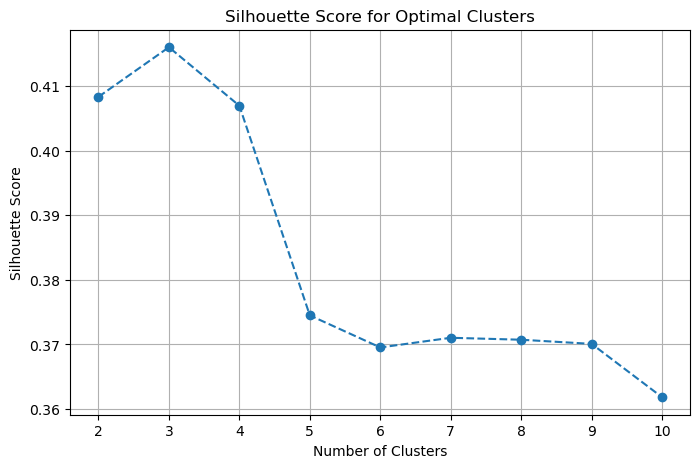

Optimal number of clusters: 3


In [350]:
# Apply ECDF filtering to all features
red_filtered = red_wine.copy()
# white_filtered = white_wine.copy()

for feature in features:
    red_filtered = filter_ecdf(red_filtered, feature)
    # white_filtered = filter_ecdf(white_filtered, feature)

# red_filtered.head()

# Normalize the filtered data
scaler = StandardScaler()
red_scaled = scaler.fit_transform(red_filtered[features])
# white_scaled = scaler.fit_transform(white_filtered[features])

# Convert back to DataFrame
red_scaled_df = pd.DataFrame(red_scaled, columns=features)
# white_scaled_df = pd.DataFrame(white_scaled, columns=features)

red_scaled_df

# Now use the filtered and scaled data for clustering
best_k_red = find_optimal_clusters(red_scaled_df)
# best_k_white = find_optimal_clusters(white_scaled_df)

## Perform Kmeans Clustering
Use the optimized number of cluster found(**best_k_red**, **best_k_white**), perform K-means clustering

In [351]:

def perform_kmeans_clustering(data, n_clusters, wine_type):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    
    # Add cluster labels to the DataFrame
    data["Cluster"] = labels
    
    # Plot clustering results using first two features (for visualization)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=labels, palette="bright", s=50)
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.title(f"K-Means Clustering ({wine_type} Wine)")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.show()
    sns.pairplot(data, hue="Cluster", palette="bright")
    plt.show()
    
    return data


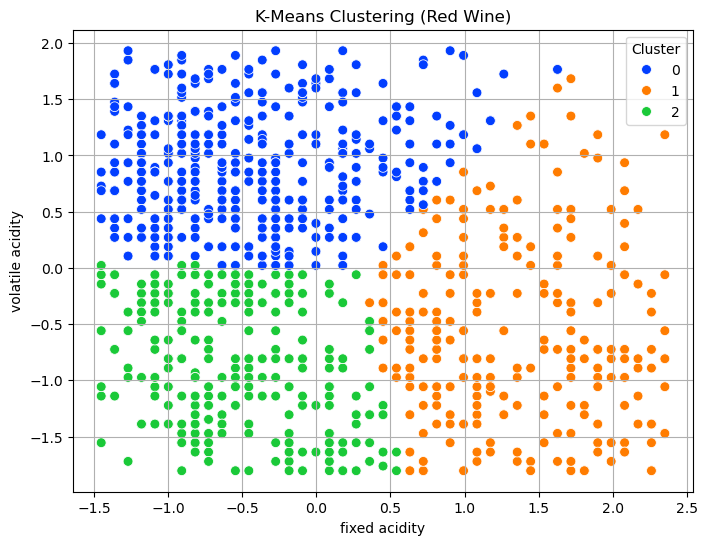

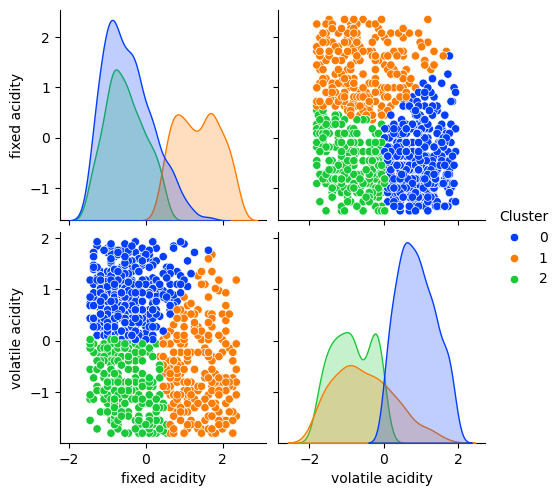

,volatile acidity,fixed acidity,Cluster
0,1.433175,-0.638027,0
579,1.557655,-0.366135,0
580,0.686294,0.630804,0
581,0.603307,-0.819289,0
583,1.557655,-0.456766,0
585,0.603307,-0.819289,0
586,0.686294,0.630804,0
587,1.848108,0.721435,0
589,0.354347,-1.181812,0
591,1.101228,-0.819289,0


In [352]:
red_clustered = perform_kmeans_clustering(red_scaled_df, best_k_red, "Red")
red_clustered[['volatile acidity', 'fixed acidity', 'Cluster']].sort_values('Cluster').head(20)


### Compute for silhoutte score

In [353]:
# Compute Silhouette Score
def compute_silhouette(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1 and -1 in unique_labels:
        # Exclude noise points
        filtered_data = data[labels != -1]
        filtered_labels = labels[labels != -1]
        if len(np.unique(filtered_labels)) > 1:
            return silhouette_score(filtered_data, filtered_labels)
        else:
            return "Silhouette score not valid (only one cluster after removing noise)"
    elif len(unique_labels) > 1:
        return silhouette_score(data, labels)
    else:
        return "Silhouette score not valid (only one cluster or too much noise)"

## DBSCAN Clustering

In [354]:
# Visualization of DBSCAN Clusters
def plot_dbscan(data, labels, title):
    plt.figure(figsize=(8, 6))
    unique_clusters = np.unique(labels)
    palette = sns.color_palette("viridis", len(unique_clusters) - 1)  # Exclude noise
    
    for i, cluster in enumerate(unique_clusters):
        if cluster == -1:
            color = 'none'  # Noise points
            label = 'Noise'
        else:
            color = palette[i-1]
            label = f'Cluster {cluster}'
        plt.scatter(data[labels == cluster, 1], data[labels == cluster, 2], 
                    color=color, label=label, alpha=0.5)
    
    plt.xlabel(features[1])
    plt.ylabel(features[2])
    plt.title(title)
    plt.legend()
    plt.show()


## Find the best Epsilon to use

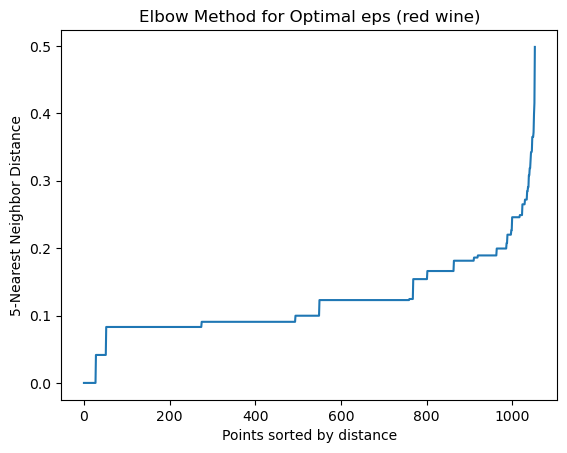

In [355]:
from sklearn.neighbors import NearestNeighbors

def find_best_eps(data, wine_lable, k=5):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    
    # Sort and plot the k-distance
    distances = np.sort(distances[:, -1])  # Get the kth nearest distances
    plt.plot(distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-Nearest Neighbor Distance")
    plt.title(f"Elbow Method for Optimal eps ({wine_lable})")
    plt.show()

# Find best eps
find_best_eps(red_scaled,'red wine', k=5)
# find_best_eps(white_scaled,'white wine', k=5)

In [356]:
best_eps_red = 0.2  # Adjust based on elbow method
# best_eps_white = 2  # Adjust based on elbow method

dbscan_red = DBSCAN(eps=best_eps_red, min_samples=10).fit(red_scaled)
# dbscan_white = DBSCAN(eps=best_eps_white, min_samples=10).fit(white_scaled)


# Check clusters again
print("Red Wine Clusters:", np.unique(dbscan_red.labels_))
# print("White Wine Clusters:", np.unique(dbscan_white.labels_))


print("Red Wine Silhouette Score:", compute_silhouette(red_scaled, dbscan_red.labels_))
# print("White Wine Silhouette Score:", compute_silhouette(white_scaled, dbscan_white.labels_))

# Plot improved DBSCAN clusters
plot_dbscan(red_scaled, dbscan_red.labels_, "DBSCAN Clusters - Red Wine (Tuned)")
# plot_dbscan(white_scaled, dbscan_white.labels_, "DBSCAN Clusters - White Wine (Tuned)")

Red Wine Clusters: [-1  0  1  2  3  4  5  6  7]
Red Wine Silhouette Score: 0.08666422017099346


IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 800x600 with 0 Axes>

## Agglomerative Clustering

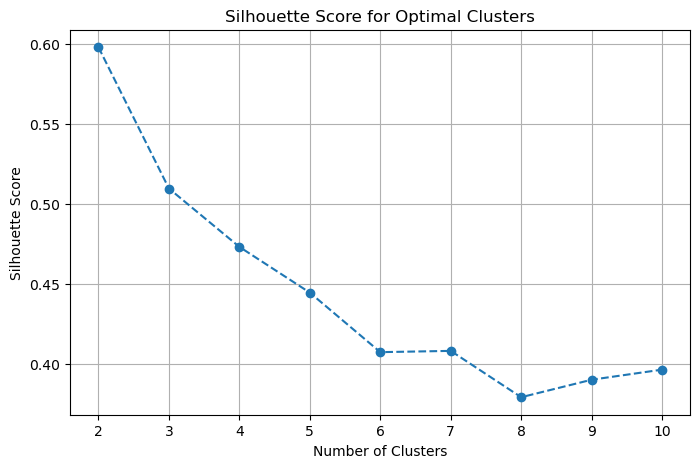

Optimal number of clusters: 2


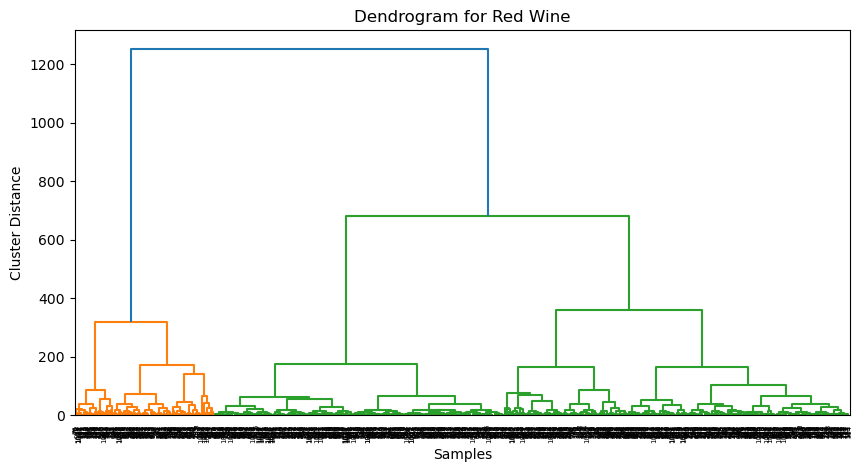

In [ ]:
def apply_agglomerative_clustering(data, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = model.fit_predict(data)
    return labels

# Find optimal clusters using filtered data
n_clusters_red = find_optimal_clusters(red_filtered)
# n_clusters_white = find_optimal_clusters(white_filtered)

# Apply Agglomerative Clustering to filtered data
red_labels = apply_agglomerative_clustering(red_filtered, n_clusters_red)
# white_labels = apply_agglomerative_clustering(white_filtered, n_clusters_white)

# Update dendrogram function to use filtered data
def plot_dendrogram(data, wine_type):
    plt.figure(figsize=(10, 5))
    Z = linkage(data, method='ward')
    dendrogram(Z)
    plt.title(f"Dendrogram for {wine_type} Wine")
    plt.xlabel("Samples")
    plt.ylabel("Cluster Distance")
    plt.show()

# Plot dendrograms using the filtered data
plot_dendrogram(red_filtered, "Red")
# plot_dendrogram(white_filtered, "White")